# Setup

Let's import the modules we need:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from train import get_pipeline
from train import prepare_data
%matplotlib inline

# Data Exploration

Let's load the data and take a look at what columns we have.

In [2]:
data = pd.read_csv("../data/kc_house_data.csv")
display(data.head())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
fixed_data = data.assign(price_per_sqft=data.price / data.sqft_living)


How many samples do we have?

In [4]:
len(data)

21613

Are there any missing values?

In [5]:
data.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

How many outliers do we have for each column?

In [6]:
quantile1 = fixed_data.quantile(0.25)
quantile3 = fixed_data.quantile(0.75)
interquartile_range = quantile3 - quantile1
((fixed_data < (quantile1 - 1.5 * interquartile_range)) | (fixed_data > (quantile3 + 1.5 * interquartile_range))).sum()

bathrooms           571
bedrooms            546
condition            30
date              21613
floors                0
grade              1911
id                    0
lat                   2
long                256
price              1146
price_per_sqft      708
sqft_above          611
sqft_basement       496
sqft_living         572
sqft_living15       544
sqft_lot           2425
sqft_lot15         2194
view               2124
waterfront          163
yr_built              0
yr_renovated        914
zipcode               0
dtype: int64

## Zipcode

It makes sense to treat the zipcode as a categorical variable, so we would have to one-hot encode it. Since we have 70 unique zipcodes in the dataset, dimensionality would explode. We need to do something smarter than that.

We can calculate the average of the price per sqft for each zipcode, and replace the zipcode column with that value. This will allow us to have a continuous variable that takes into account the neighborhood.

In [7]:
print("Unique zipcodes: {}".format(len(data.zipcode.unique())))

Unique zipcodes: 70


## Price

Let's examine how the skewness of price vs price per sqft looks, and how log transforming it changes that.

('Skewness of price/sqft:', 4.023789858140135)
('Skewness of log transformed price/sqft:', 0.42804680472976364)
('Skewness of price/sqft:', 1.2480521920494403)
('Skewness of log transformed price/sqft:', 0.14531154545144953)


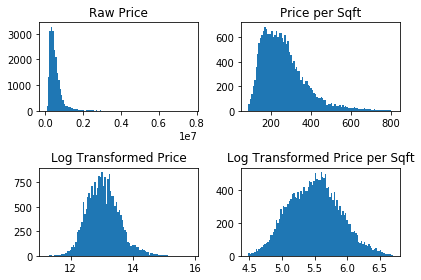

In [8]:
from scipy.stats import skew


def create_price_hist(ax, title, data):
    ax.hist(data, bins=100)
    ax.set_title(title)

price_log = np.log1p(fixed_data.price)
print("Skewness of price/sqft:", skew(fixed_data.price))
print("Skewness of log transformed price/sqft:", skew(price_log))

price_per_sqft_log = np.log1p(fixed_data.price_per_sqft)
print("Skewness of price/sqft:", skew(fixed_data.price_per_sqft))
print("Skewness of log transformed price/sqft:", skew(price_per_sqft_log))

fig, ((ax_price, ax_per_sqft), (ax_price_log, ax_per_sqft_log)) = plt.subplots(nrows=2, ncols=2)

create_price_hist(ax_price, "Raw Price", fixed_data.price)
create_price_hist(ax_per_sqft, "Price per Sqft", fixed_data.price_per_sqft)
create_price_hist(ax_price_log, "Log Transformed Price", price_log)
create_price_hist(ax_per_sqft_log, "Log Transformed Price per Sqft", price_per_sqft_log)

plt.tight_layout()
plt.show()

In [9]:
(data.price/100).describe()

count    21613.000000
mean      5400.881418
std       3671.271965
min        750.000000
25%       3219.500000
50%       4500.000000
75%       6450.000000
max      77000.000000
Name: price, dtype: float64

In [10]:
fixed_data.price_per_sqft.describe()

count    21613.000000
mean       264.156594
std        110.060793
min         87.588235
25%        182.291667
50%        244.644550
75%        318.322981
max        810.138889
Name: price_per_sqft, dtype: float64

# Building the model

Here we prepare the data for use by the algorithms:

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import expon, uniform
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor, BaggingRegressor

prepared_data = prepare_data(data)

X = prepared_data.drop('price_per_sqft', axis=1)
y = prepared_data['price_per_sqft']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Next we create pipelines for each other estimators we want to evaluate, and see how they perform:

In [12]:
estimators = [get_pipeline(GradientBoostingRegressor(random_state=42)),
              get_pipeline(AdaBoostRegressor(random_state=42)),
              get_pipeline(RandomForestRegressor(random_state=42))]
scores = map(lambda clf: clf.fit(X_train, y_train).score(X_test, y_test), estimators)
dict(zip(("gradient_boosting", "ada_boost", "random_forest"), scores))

{'ada_boost': 0.47654512137921423,
 'gradient_boosting': 0.77797034981188107,
 'random_forest': 0.76922999519128699}

Since gradient boosting performs best we move on to tune its parameters:

In [13]:
randomized_search = RandomizedSearchCV(
    get_pipeline(GradientBoostingRegressor(random_state=42)),
    param_distributions={"estimator__learning_rate": expon(scale=.03), 
                         "estimator__n_estimators":[100, 500, 700, 800], 
                         "estimator__subsample": uniform(0., 1.) }, 
    random_state=42,
    cv=5)
randomized_search.fit(X_train, y_train)
randomized_search.score(X_test, y_test)

0.81028079137574782

Let's examine the result:

In [14]:
for param in randomized_search.best_params_:
    print("{}: {}".format(param, randomized_search.best_params_[param]))

estimator__subsample: 0.456069984217
estimator__learning_rate: 0.109208986609
estimator__n_estimators: 700


This is the final model:

In [15]:
randomized_search.best_estimator_

Pipeline(memory=None,
     steps=[('zipcode_average', ZipcodeTransformer()), ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('log', FunctionTransformer(accept_sparse=False, func=<ufunc 'log1p'>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=True)), ('estimator...='auto', random_state=42,
             subsample=0.45606998421703593, verbose=0, warm_start=False))])

It's interesting to see what the learning curve looks for our model.

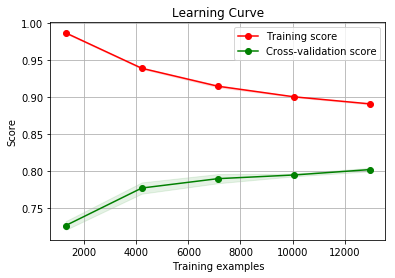

In [16]:
from plot_learning_curve import plot_learning_curve

clf = get_pipeline(GradientBoostingRegressor(learning_rate=0.109208986609, 
                                             n_estimators=700, 
                                             subsample=0.456069984217))

plot_learning_curve(clf, "Learning Curve", X_train, y_train, cv=5, n_jobs=4)
plt.show()

How well does the trained model perform on different parts of the dataset?

In [34]:
from sklearn.model_selection import cross_val_score

clf = get_pipeline(GradientBoostingRegressor(learning_rate=0.109208986609, 
                                             n_estimators=700, 
                                             subsample=0.456069984217))


scores = cross_val_score(clf, X, y, cv=10)
print(scores)
print(scores.mean())
print(scores.min())

[ 0.79215415  0.81185199  0.80325574  0.81568846  0.81922645  0.7979252
  0.8007331   0.81979057  0.79808281  0.83080882]
0.808951728782
0.792154145565


# Benchmark

Here we try to see how well our model performs when compared to the benchmark:

In [18]:
from sklearn.linear_model import LinearRegression

benchmark = get_pipeline(LinearRegression())
benchmark.fit(X_train, y_train)
benchmark.score(X_test, y_test)

/Users/yavpau/Envs/capstone/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


0.71022557772698591

So we get 0.81028079137574782 for the final model vs 0.71022557772698591 for the benchmark model. Not bad.